# FCFS-Scheduling 

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import pandas as pd
from collections import defaultdict

In [2]:
basic_data_path = get_path("data", "basic")

In [3]:
df_jssp = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [4]:
df_times = pd.read_csv(basic_data_path / "00_arrivals.csv")
df_times 

,Job,Arrival
0,job 5,83.59
1,job 8,107.22
2,job 7,125.26
3,job 0,181.45
4,job 4,270.56
5,job 9,309.13
6,job 3,586.13
7,job 2,667.09
8,job 1,713.06
9,job 6,747.96


In [5]:
# FCFS with Arrivals
def schedule_fcfs_with_arrivals(df_jssp: pd.DataFrame, arrival_df: pd.DataFrame) -> pd.DataFrame:
    """
    FCFS-Scheduling mit Job-Ankunftszeiten – optimierte Version.

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - arrival_df: DataFrame mit ['Job','Arrival'].
    """
    # Arrival-Zeiten als Dict
    arrival = arrival_df.set_index('Job')['Arrival'].to_dict()

    # Preprocessing: Operationen als Dict (Job, Operation) → Row
    ops_dict = {(row['Job'], row['Operation']): row for _, row in df_jssp.iterrows()}

    # Status-Tracker
    next_op = {job: 0 for job in df_jssp['Job'].unique()}
    job_ready = arrival.copy()
    machine_ready = defaultdict(float)
    remaining = len(df_jssp)

    schedule = []
    while remaining > 0:
        best = None  # (job, start, dur, machine, op_idx)

        # Suche FCFS-geeignete Operation
        for job, op_idx in next_op.items():
            if (job, op_idx) not in ops_dict:
                continue
            row = ops_dict[(job, op_idx)]
            m = int(row['Machine'].lstrip('M'))  # optional: in ops_dict vorverarbeiten
            dur = row['Processing Time']
            earliest = max(job_ready[job], machine_ready[m])
            if (best is None or
                earliest < best[1] or
                (earliest == best[1] and arrival[job] < arrival[best[0]])):
                best = (job, earliest, dur, m, op_idx)

        job, start, dur, m, op_idx = best
        end = start + dur
        schedule.append({
            'Job': job,
            'Operation': op_idx,
            'Arrival': arrival[job],
            'Machine': f'M{m}',
            'Start': start,
            'Processing Time': dur,
            'End': end
        })
        job_ready[job] = end
        machine_ready[m] = end
        next_op[job] += 1
        remaining -= 1

    df_schedule = pd.DataFrame(schedule)
    return df_schedule.sort_values(['Arrival', 'Start']).reset_index(drop=True)


In [6]:
df_plan = schedule_fcfs_with_arrivals(df_jssp, df_times)
df_plan

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,job 5,0,83.59,M2,83.59,84,167.59
1,job 5,1,83.59,M1,167.59,2,169.59
2,job 5,2,83.59,M5,169.59,52,221.59
3,job 5,3,83.59,M3,221.59,95,316.59
4,job 5,4,83.59,M8,316.59,48,364.59
...,...,...,...,...,...,...,...
95,job 6,5,747.96,M5,1183.22,21,1204.22
96,job 6,6,747.96,M9,1204.22,32,1236.22
97,job 6,7,747.96,M8,1236.22,89,1325.22
98,job 6,8,747.96,M7,1351.22,30,1381.22


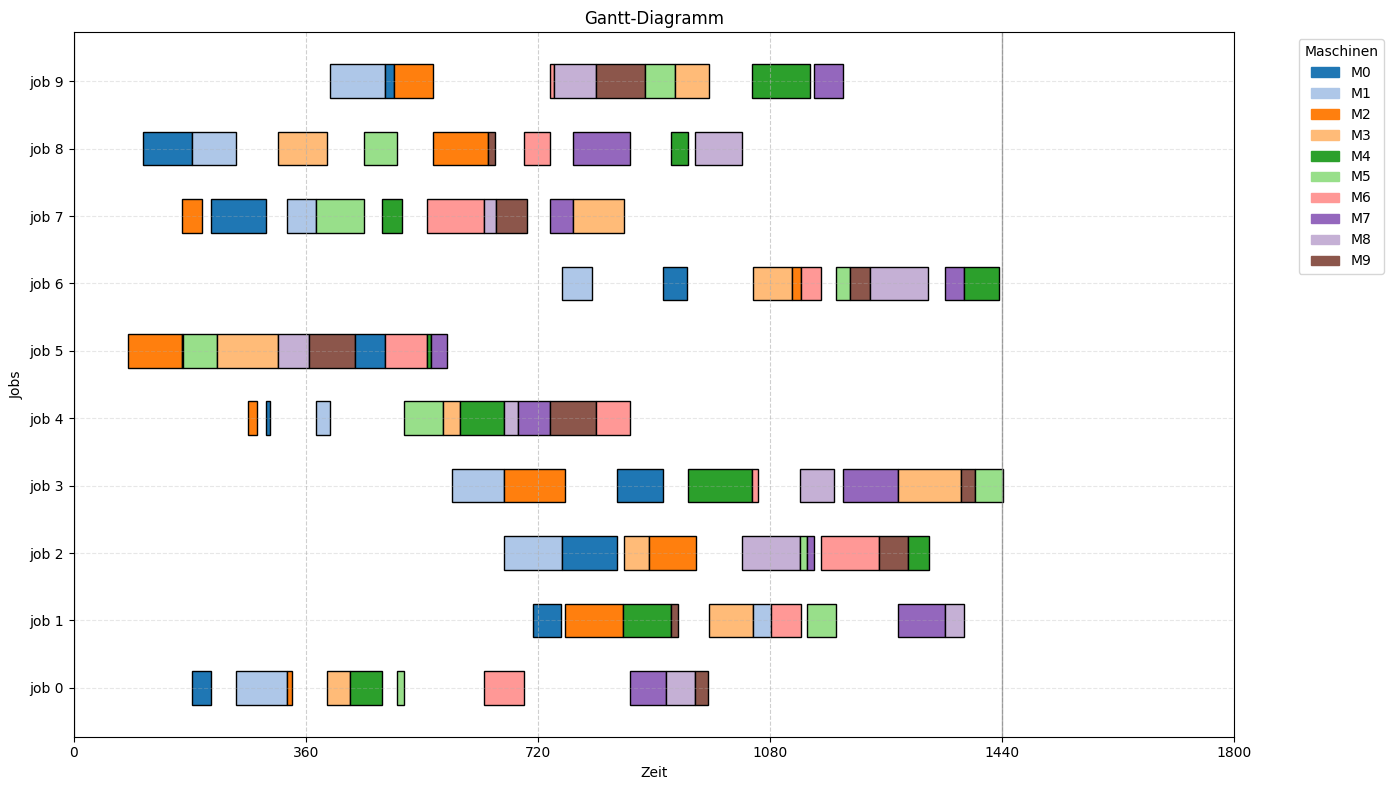

In [7]:
show.plot_gantt_jobs(df_plan)

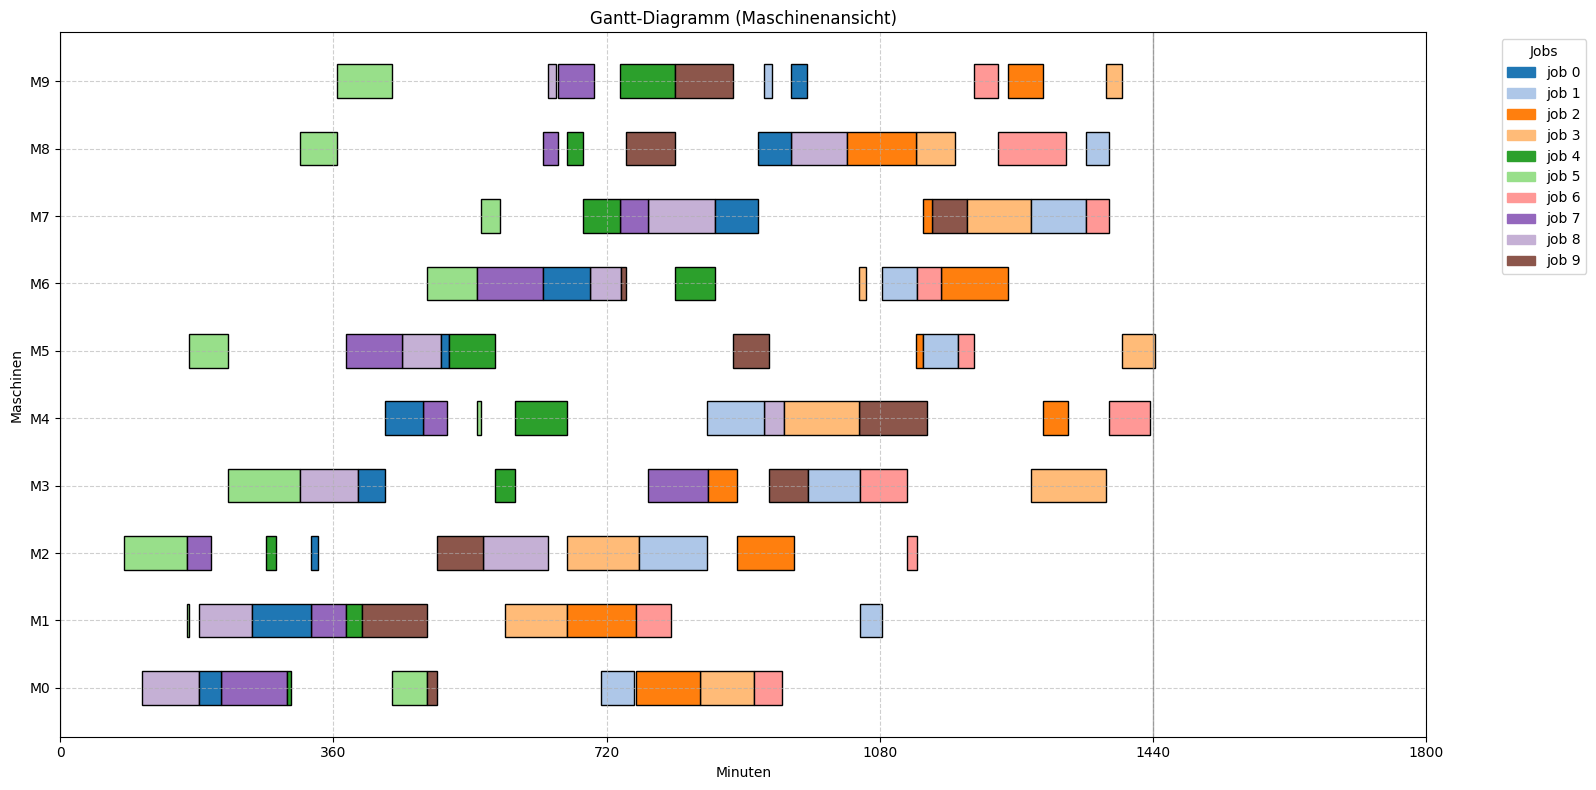

In [8]:
show.plot_gantt_machines(df_plan)

In [9]:
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True